# Inverse Ising Problem
The inverse problem is to learn the values of the weight matrix using the statistics of the system. This code infers the interaction parameters of the classical hamiltonian from the statistics using a classical Boltzmann machine.

In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

In [2]:
# WEIGHT FUNCTIONS
#-----------------------------------------------------------------------------------------------------------
def generate_weights_nearest_neighbour(L, w, h):
    '''Generates weights array with only nearest neighbour interactions and periodic boundary conditions''' 
    N = L**2
    W = np.zeros((N, N))
    for i in range(L):
        for j in range(L):
            site  = L * i             + j
            east  = L * i             + (j + 1) % L
            west  = L * i             + (j - 1) % L
            north = L * ((i + 1) % L) + j
            south = L * ((i - 1) % L) + j
            
            W[site, east]  += w
            W[site, west]  += w
            W[site, north] += w
            W[site, south] += w
    H = (np.ones((N)) * h) / L
    return W, H

def generate_weights_fully_connected(L, w, h):
    '''Generates weights array for a fully connected system'''
    N = L**2
    W = (np.ones((N, N)) * w) / N 
    np.fill_diagonal(W, 0)
    H = (np.ones((N)) * h) / L
    return W, H

def generate_weights_random(L, w, h, sigma, seed):
    '''Generates a symmetric random weights array drawn from a normal distribution for a given seed'''
    N = L**2      
    rng = np.random.default_rng(seed)                    #  set random seed for reproduciblity
    W_assym = rng.normal(w/N, sigma/(N**(1/2)),(N, N))   #  get normal distributed weight matrix
    W = (W_assym+ W_assym.T)/2                           #  symmetrize the random matrix 
    np.fill_diagonal(W, 0)                               #  set diagonal entries to 0
    H = rng.normal(h/N, sigma/(N**(1/2)),(N))            #  get normal distributed H
    return W , H

In [3]:
###  SIMULATION HELPER FUNCTIONS
#----------------------------------------------------------------------
def all_possible_configs(L):
    '''Generates all possible configurations of a binary spin system of size N'''
    N = L**2
    configs = np.zeros((2**N,N))
    for i in range(2**N):
        config = np.array([1 if x == '1' else -1 for x in np.binary_repr(i, width=N)])
        configs[i] = config
    return configs

@numba.njit
def initial_config(L: int) -> np.ndarray:
    '''Generates a 1D array of length N with random binary spin values'''
    return (np.random.randint(0, 2, size=L**2) * 2 - 1).astype(np.float64)

@numba.njit
def calcEnergy(config: np.ndarray, W: np.ndarray, H: np.ndarray) -> float:
    '''Calculates the energy of a given configuration'''
    config_contiguous = np.ascontiguousarray(config)        # use contiguos array for faster numba 
    energy = -np.dot(config_contiguous.T, np.dot(W, config_contiguous)) / 2 - np.dot(H, config_contiguous)
    return energy

@numba.njit
def calcMag(config: np.ndarray) -> float:
    ''' Magnetizations of a given configuration '''
    return np.sum(config)

@numba.njit
def calcCorr(config: np.ndarray) -> np.ndarray: 
    '''Calculates the spin-spin correlations of a given configuration. Returns a NxN matrix with the correlations'''
    return np.outer(config, config.T)

@numba.njit
def heat_bath_move(config: np.ndarray, W: np.ndarray, H: np.ndarray, beta: float) -> np.ndarray:
    '''Implements a Monte Carlo sweep using the heat bath algorithm'''
    N = len(config)
    for _ in range(N):                                          #  this for loop ensures we perform a sweep
        a  = np.random.randint(N)                               #  choose a random spin i 
        lf = config[a] * (np.dot(W[a], config) + H[a])          #  calculate local field energy of spin i
        p = 1 / (1 + np.exp(2 * beta * lf))                     #  probability of flipping spin i
        if np.random.rand() < p:
            config[a] *= -1
    return config

@numba.njit
def log_likelihood(W, H, Ci, CiCj):
    '''Computes the log-likelihood of the model'''     # -Log(Z) = 0; it's just a constant (?)
    energies = -np.dot(W, CiCj) - np.dot(H,Ci)    
    #Z = np.sum(np.exp(-energies))
    #logZ = np.log(Z)
    return np.sum(energies)

Since the free statistics have to be calculated at each iteration of the gradient ascent loop, we want our functions to calculate the free statistics as efficient as possible. We first start by simplifying the solver functions defined for the forward Ising problem. We can recycle a lot of the code that we used for the forward Ising problem.

In [4]:
###  GET SIMPLIFIED SOLVER FUNCTIONS
#----------------------------------------------------------------------
@numba.njit
def ising_solve_exact_simplified(L, W, H, T, configs):    
    '''Calculates the free statistics for a single temperature using exact calculation'''
    N = L**2
    beta = 1.0/T 
    Z, C1, C2  = 0, np.zeros((N)), np.zeros((N,N))    #  initialize arrays to store variables                       
                                           
    for config in configs:
        Ene  = calcEnergy(config,W,H)
        Corr = calcCorr(config) 
        p    = np.exp(-beta * Ene)                    #  non-normalized probability of this 
                                                      #  configuration at this temperature
        Z  +=  p                                        
        C1 +=  p * config                               
        C2 +=  p * Corr

    Ci   = C1 / Z
    CiCj = C2 / Z
        
    return Ci,CiCj

@numba.njit
def ising_solve_mc_simplified(L, W, H, T, config, mcSteps):    
    '''Calculate the free statistics for a single temperature using Monte Carlo Heat Bath sampling'''
    N = L**2
    beta = 1.0/T  
    C1, C2 = np.zeros((N)),np.zeros((N,N))           #  initialize arrays to store variables 

    for _ in range(mcSteps):   
        config = heat_bath_move(config, W, H, beta)  #  performs a sweep. no need to equilibrate.  
        Corr   = calcCorr(config)      
 
        C1 += config
        C2 += Corr
   
    Ci    = C1 / mcSteps
    CiCj  = C2 / mcSteps
        
    return Ci,CiCj,config

I've checked and the exact function recover the exact same values for Ci and CiCj as the more expansive version does. Given enough mcSteps, the simplified mc function also converges to the same values as the non-simplified mc function.

In [5]:
## SOLVE USING EXACT COMPUTATION 
#----------------------------------------------------------------------
def initialize(L,w,h,sigma,seed_clamp,seed_free, no_config = False):
    #  initialize weight matrix
    if W_type == 0:                                           
        W_clamp, H_clamp = generate_weights_random(L, w, h, sigma, seed_clamp)         
    elif W_type == 1:                                         
        W_clamp, H_clamp = generate_weights_nearest_neighbour(L,w,h)
    elif W_type == 2:
        W_clamp, H_clamp = generate_weights_fully_connected(L,w,h) 
    else:
        print("Non-valid weight matrix type")

    if no_config == False:
        configs = all_possible_configs(L)
    else:
        configs = np.zeros((L,L))

    #  get random initial weights that generate free statistics 
    W, H = generate_weights_random(L, w, h, sigma, seed_free)  #  use different seed than for clamped stats
    return W, H, W_clamp, H_clamp, configs

@numba.njit
def solve_inverse_ising(L, T, eqSteps, mcSteps, W, H, W_clamp, H_clamp, configs, Clamp_type, Free_type, threshold, maxiter, eta):
    '''Solves the inverse Ising problem. Returns weight matrices that generated the clamped statistics 
       and the inferred weight matrix'''
    beta = 1.0 / T 
    
    #  generate the clamped statistics based on solver type
    if Clamp_type == 0:
        Ci_clamp, CiCj_clamp = ising_solve_exact_simplified(L, W_clamp, H_clamp, T, configs)

    if Clamp_type == 1:
        config = initial_config(L)                             #  intialize a state
        for _ in range(eqSteps):                               #  equilibrate
            config    = heat_bath_move(config, W_clamp, H_clamp, beta)
        Ci_clamp, CiCj_clamp, config = ising_solve_mc_simplified(L, W_clamp, H_clamp, T, config, mcSteps)   
        
    config = initial_config(L)                                 #  initialize new state for free statistics 
    
    #  initialize gradient ascent values  
    it    = 0
    H_max = W_max = 1    
    Hmax_values, Wmax_values, Li_values = [], [], []  #store values to plot
    
    while (it < maxiter and (H_max > threshold and W_max > threshold)):    #  start gradient ascent
        it += 1

        #generate free statistics based on type of solver
        if Free_type == 0:
            Ci_free, CiCj_free = ising_solve_exact_simplified(L, W, H, T, configs) 

        if Free_type == 1:
            Ci_free, CiCj_free, config = ising_solve_mc_simplified(L, W, H, T, config, mcSteps)
            # if it % 10 == 0:
            #     print('Iteration %.f completed'% it)           #  feedback for long MCMC simulations
            
        H     = H + eta * (Ci_clamp   - Ci_free)               #  update weight matrix based on statistics  
        W     = W + eta * (CiCj_clamp - CiCj_free)

        H_max = np.abs(np.max(H - H_clamp))
        W_max = np.abs(np.max(W - W_clamp))
        Li    = log_likelihood(W, H, Ci_free, CiCj_free)
        
        Hmax_values.append(H_max)
        Wmax_values.append(W_max)
        Li_values.append(Li)
        
    return W, H, W_clamp, H_clamp, it, Hmax_values, Wmax_values, Li_values

In [6]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_scatter(ax, x, y, xlabel, ylabel, color, size=10):
    '''Creates a scatter subplot'''
    ax.scatter(x, y, s=size, marker='o', color=color)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_yscale('log')

def plot(it, Hmax, Wmax, Li, title='Convergence Plots', size=10):
    fig = plt.figure(figsize=(25, 6));                           #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    its= np.arange(1,it+1,1)

    ax1 = fig.add_subplot(1, 3, 1)
    plot_scatter(ax1, its, Wmax, "Iterations", r"$ (\Delta W)_{max}$", "Coral", size)
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax2 = fig.add_subplot(1, 3, 2)
    plot_scatter(ax2, its, Hmax, "Iterations", r"$ (\Delta H)_{max}$ ", "HotPink", size)
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
   
    
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.scatter(its, Li, s=size, marker='o', color="ForestGreen")
    ax3.set_xlabel("Iterations", fontsize=20)
    ax3.set_ylabel("Log Likelihood", fontsize=20)
    ax3.text(0, 1.0, 'C.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

# Results Fully Connected Ferro

In [7]:
##  PARAMETERS
#----------------------------------------------------------------------
# model parameters
L           = 4        #  linear dimension of the LxL lattice
T           = 5        #  temperature scalar
w           = 1        #  strength of interactions 
h           = 0        #  strength of self-interactions
W_type      = 0        #  0 for random weights, 1 for nb, 2 for fully connected
Clamp_type  = 0        #  determine how the clamped statistics are generated (0 exact, 1 mc)
Free_type   = 0        #  determine how the free statistics are generated (0 exact, 1 mc)
eqSteps     = 2**10    #  number of MC sweeps for equilibration
mcSteps     = 2**16    #  number of MC sweeps for calculation

# gradient ascent parameters 
eta         = 1/2      #  learning rate
threshold   = 1e-17    #  threshold for stopping the gradient ascent loop
maxiter     = 700      #  maximum number of gradient ascent iterations

#random weights parametes
seed_clamp  = 777       
seed_free   = 333
sigma       = .1

W, H, W_clamp, H_clamp, configs = initialize(L,w,h,sigma,seed_clamp,seed_free)

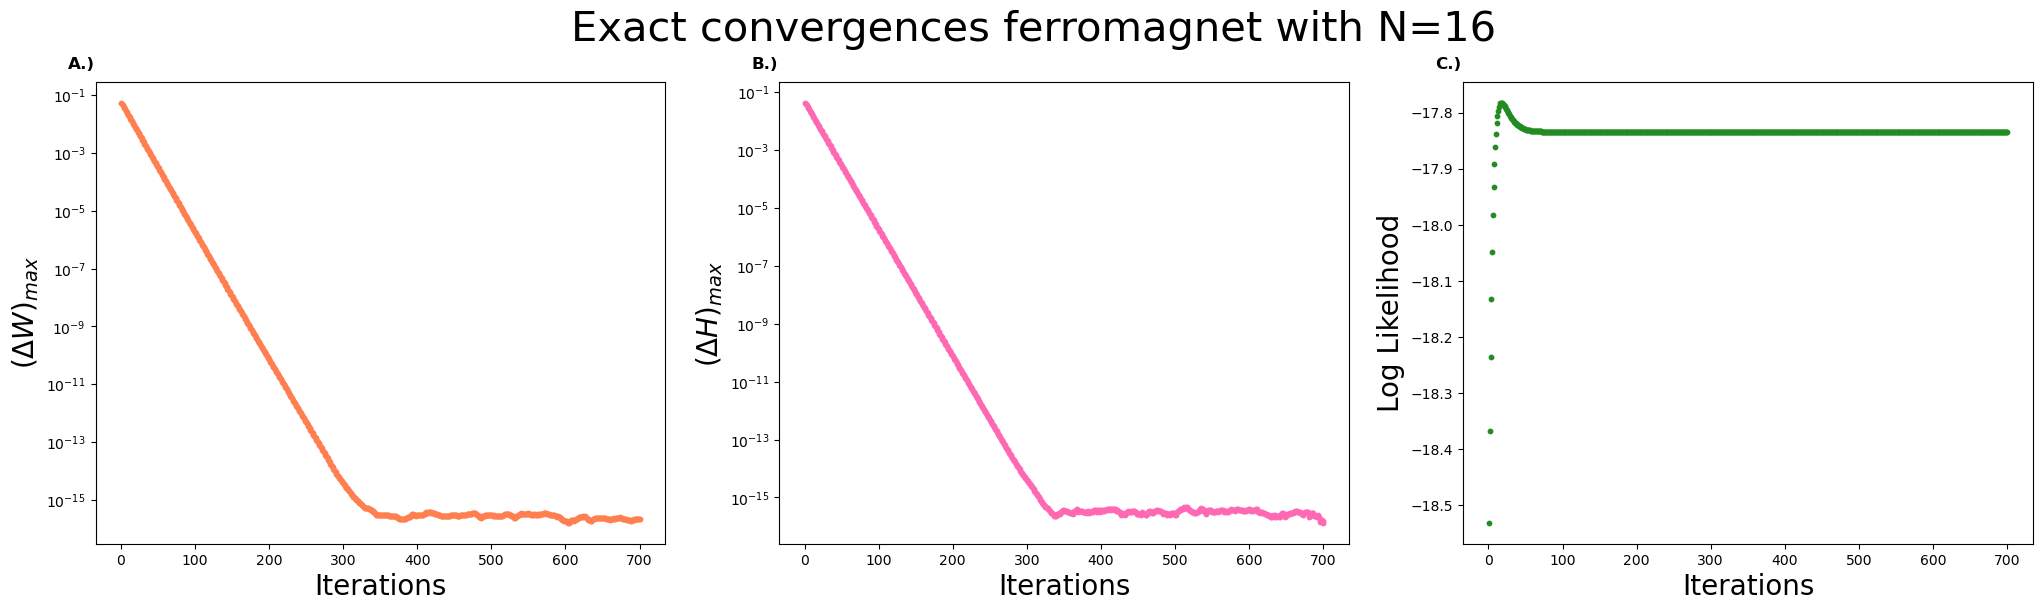

In [8]:
W, H, W_clamp, H_clamp, it, Hmax, Wmax, Li= solve_inverse_ising(L, T, eqSteps, mcSteps, W, H, W_clamp, H_clamp, configs, Clamp_type, Free_type, threshold, maxiter, eta)

plot(it, Hmax, Wmax, Li, title = ('Exact convergences ferromagnet with N=%.f'%L**2), size = 10)
plt.savefig(f"Figures/Inverse Ising Problem/Exact_ferro_L={L}_T={T}_w={w}_h={h}_eta={eta}_thresh={threshold}_it={it}.png", bbox_inches='tight')

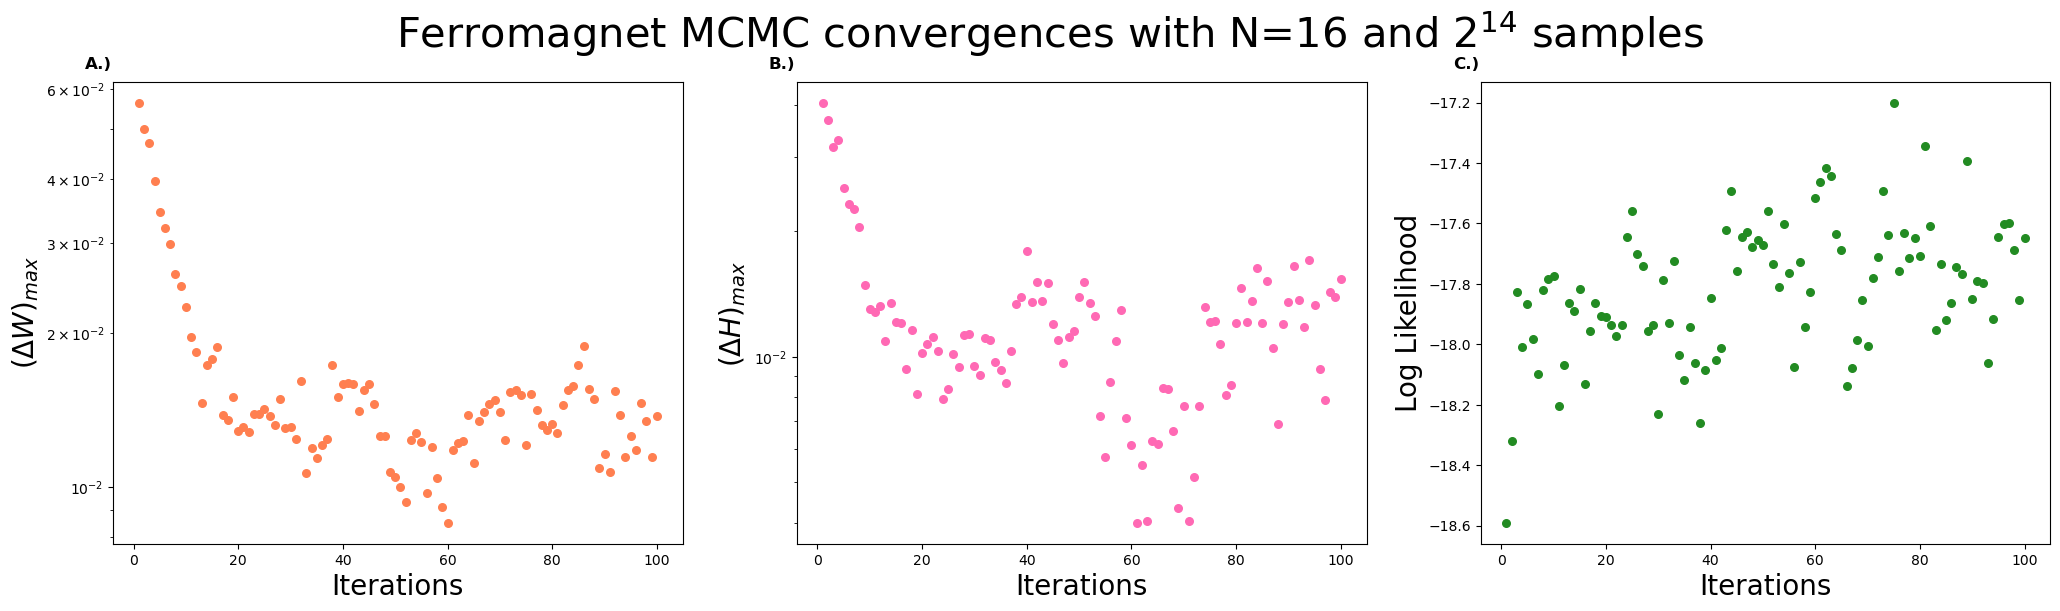

In [9]:
Free_type = 1 #generate free statistics using MCMC
maxiter = 100

W, H, W_clamp, H_clamp, configs = initialize(L,w,h,sigma,seed_clamp,seed_free)
W, H, W_clamp, H_clamp, it, Hmax, Wmax, Li= solve_inverse_ising(L, T, eqSteps, mcSteps, W, H, W_clamp, H_clamp, configs, Clamp_type, Free_type, threshold, maxiter, eta)

plot(it, Hmax, Wmax, Li, title = ('Ferromagnet MCMC convergences with N=%.f and $2^{14}$ samples'%(L**2)), size = 30)
plt.savefig(f"Figures/Inverse Ising Problem/MCMC_ferro_L={L}_T={T}_w={w}_h={h}_eta={eta}_thresh={threshold}_it={it}.png", bbox_inches='tight')

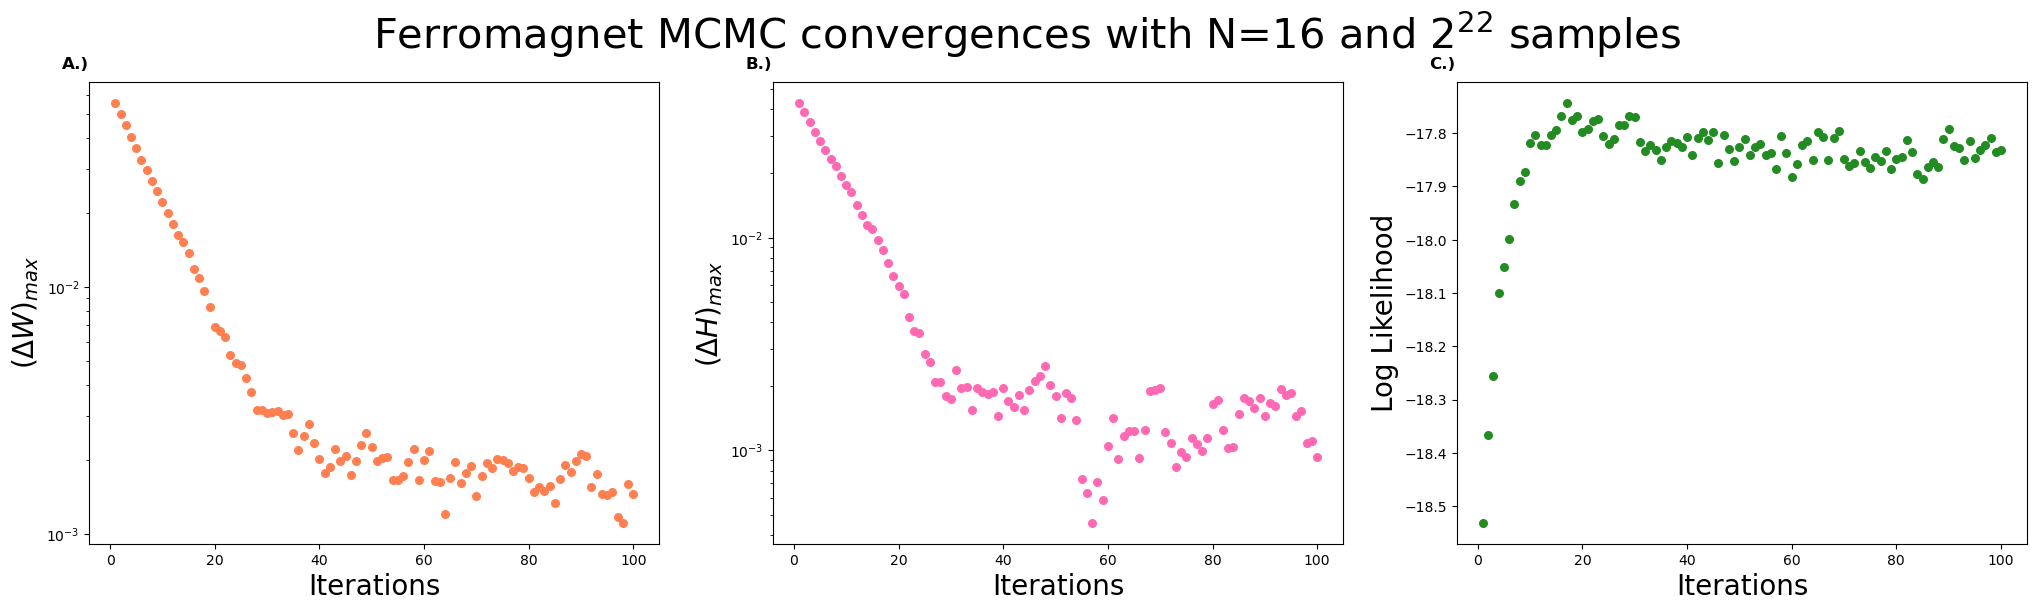

In [10]:
mcSteps     = 2**22
W, H, W_clamp, H_clamp, configs = initialize(L,w,h,sigma,seed_clamp,seed_free)
W, H, W_clamp, H_clamp, it, Hmax, Wmax, Li= solve_inverse_ising(L, T, eqSteps, mcSteps, W, H, W_clamp, H_clamp, configs, Clamp_type, Free_type, threshold, maxiter, eta)

plot(it, Hmax, Wmax, Li, title = ('Ferromagnet MCMC convergences with N=%.f and $2^{22}$ samples'%(L**2)), size = 30)
plt.savefig(f"Figures/Inverse Ising Problem/MCMC_ferro_L={L}_T={T}_w={w}_h={h}_eta={eta}_thresh={threshold}_it={it}.png", bbox_inches='tight')

# Results Fully Connected Frustrated

In [11]:
##  PARAMETERS
#----------------------------------------------------------------------
# model parameters
L           = 3        #  linear dimension of the LxL lattice
T           = 3        #  temperature scalar
w           = 0        #  strength of interactions 
h           = 0        #  strength of self-interactions
W_type      = 1        #  0 for random weights, 1 for nb, 2 for fully connected
Clamp_type  = 0        #  determine how the clamped statistics are generated (0 exact, 1 mc)
Free_type   = 0        #  determine how the free statistics are generated (0 exact, 1 mc)
eqSteps     = 2**10    #  number of MC sweeps for equilibration
mcSteps     = 2**14    #  number of MC sweeps for calculation

# gradient ascent parameters 
eta         = 1/2      #  learning rate
threshold   = 1e-30    #  threshold for stopping the gradient ascent loop
maxiter     = 2000     #  maximum number of gradient ascent iterations

#random weights parametes
seed_clamp  = 777       
seed_free   = 333
sigma       = .1

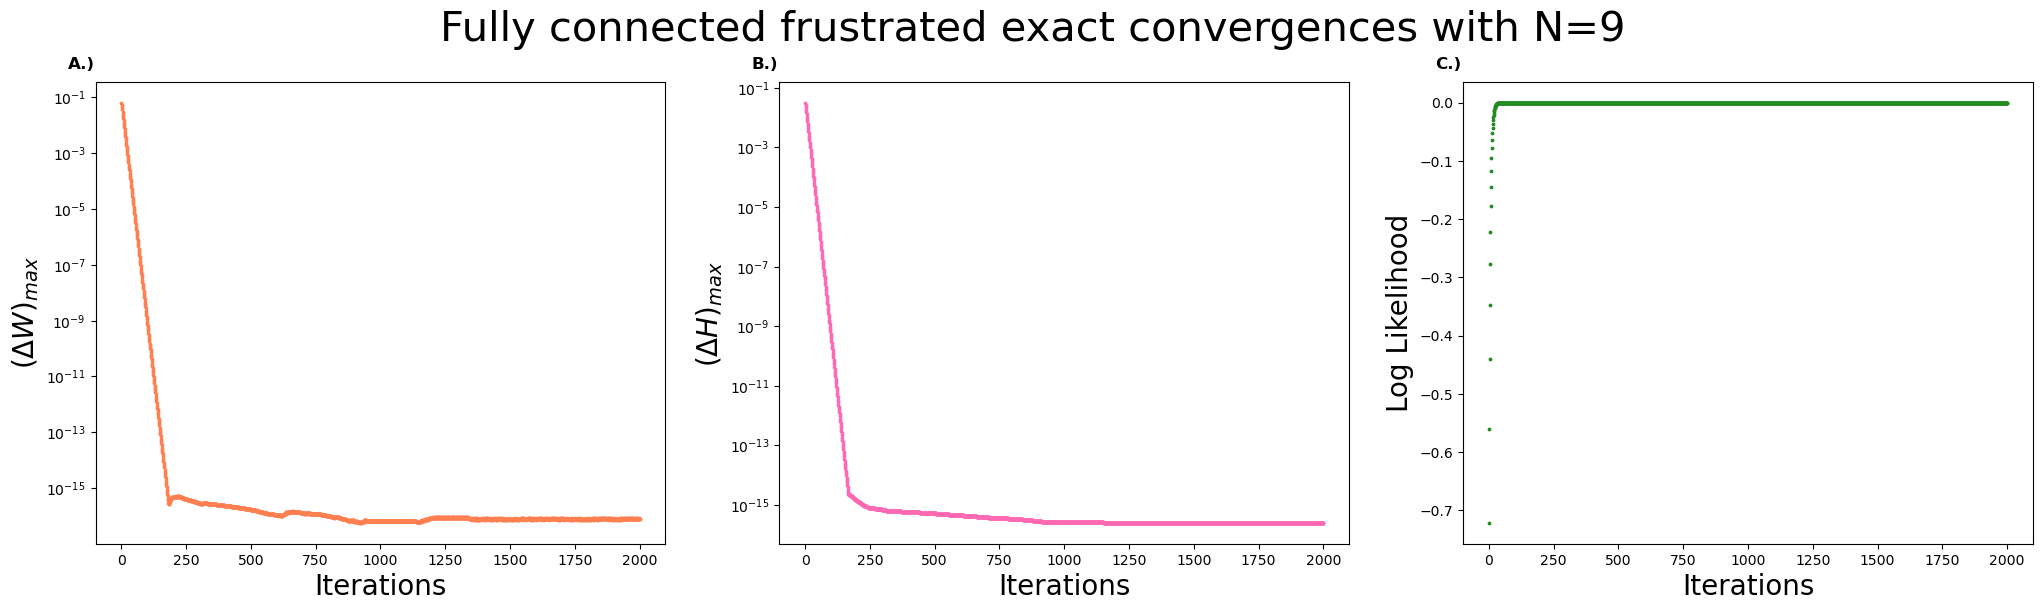

In [12]:
W, H, W_clamp, H_clamp, configs = initialize(L,w,h,sigma,seed_clamp,seed_free)
W, H, W_clamp, H_clamp, it, Hmax, Wmax, Li= solve_inverse_ising(L, T, eqSteps, mcSteps, W, H, W_clamp, H_clamp, configs, Clamp_type, Free_type, threshold, maxiter, eta)

plot(it, Hmax, Wmax, Li, title = ('Fully connected frustrated exact convergences with N=%.f'%L**2), size = 3)
plt.savefig(f"Figures/Inverse Ising Problem/Exact_frustrated_L={L}_T={T}_w={w}_h={h}_eta={eta}_thresh={threshold}_it={it}.png", bbox_inches='tight')

# Results Fully Connected Constant

In [13]:
@numba.njit
def log_likelihood(W, H, Ci, CiCj):
    '''Computes the log-likelihood of the model'''    
    energies = -np.dot(W, CiCj) - np.dot(H,Ci)    
    return np.sum(-energies)                           # flip sign               

In [14]:
##  PARAMETERS
#----------------------------------------------------------------------
# model parameters
L           = 3        #  linear dimension of the LxL lattice
T           = 5        #  temperature scalar
w           = 1        #  strength of interactions 
h           = 1        #  strength of self-interactions
W_type      = 2        #  0 for random weights, 1 for nb, 2 for fully connected
Clamp_type  = 0        #  determine how the clamped statistics are generated (0 exact, 1 mc)
Free_type   = 0        #  determine how the free statistics are generated (0 exact, 1 mc)
eqSteps     = 2**10    #  number of MC sweeps for equilibration
mcSteps     = 2**14    #  number of MC sweeps for calculation

# gradient ascent parameters 
eta         = 1/2      #  learning rate
threshold   = 1e-16    #  threshold for stopping the gradient ascent loop
maxiter     = 700      #  maximum number of gradient ascent iterations

#random weights parametes
seed_clamp  = 777       
seed_free   = 333
sigma       = .1

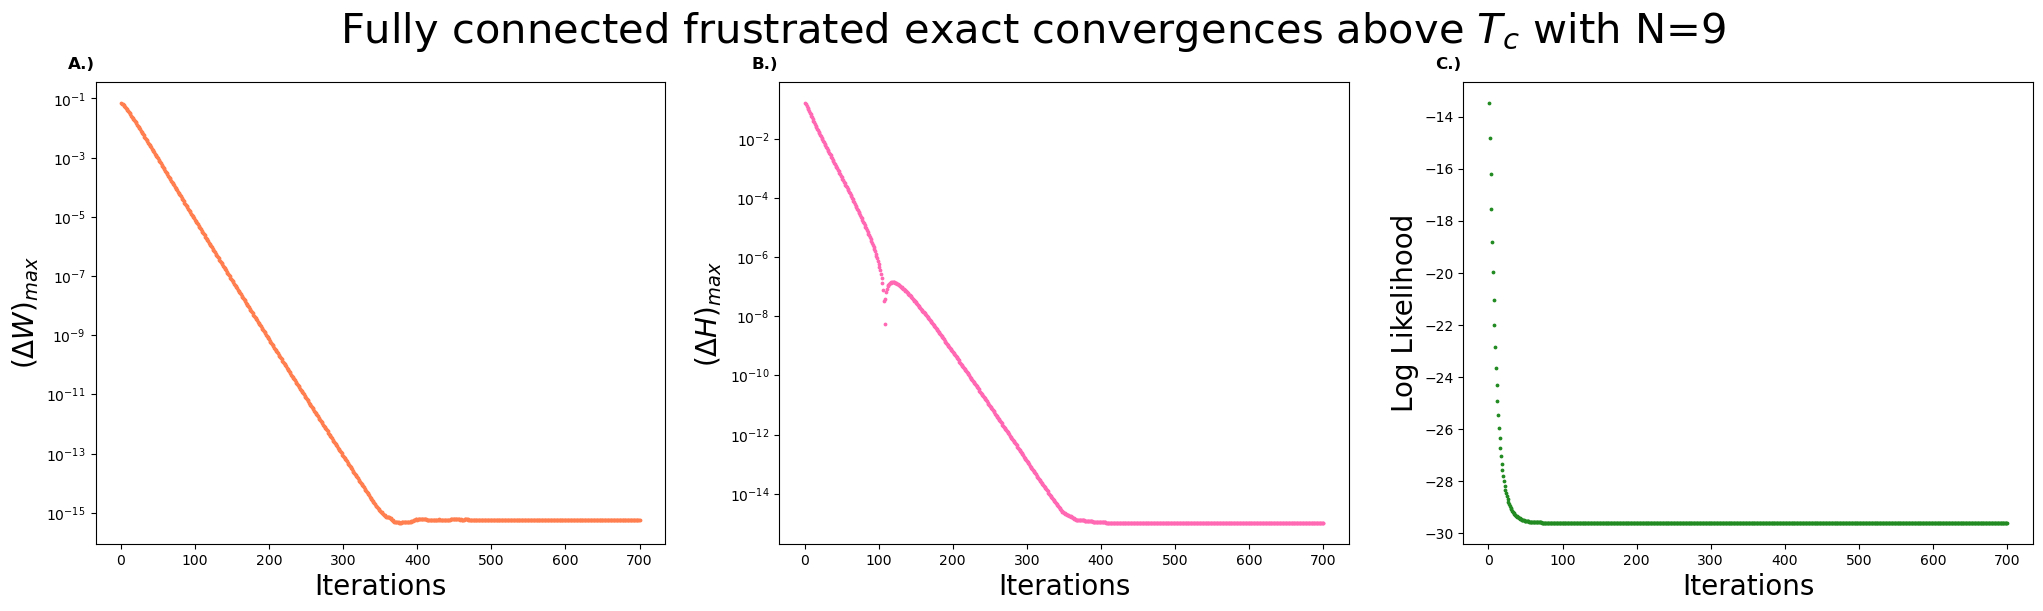

In [15]:
W, H, W_clamp, H_clamp, configs = initialize(L,w,h,sigma,seed_clamp,seed_free)
W, H, W_clamp, H_clamp, it, Hmax, Wmax, Li= solve_inverse_ising(L, T, eqSteps, mcSteps, W, H, W_clamp, H_clamp, configs, Clamp_type, Free_type, threshold, maxiter, eta)

plot(it, Hmax, Wmax, Li, title = ('Fully connected frustrated exact convergences above $T_c$ with N=%.f'%L**2), size = 3)
plt.savefig(f"Figures/Inverse Ising Problem/Exact_fc_const_above_Tc_L={L}_T={T}_w={w}_h={h}_eta={eta}_thresh={threshold}_it={it}.png", bbox_inches='tight')


## Below the critical temperature the simulation runs critically more slowly.

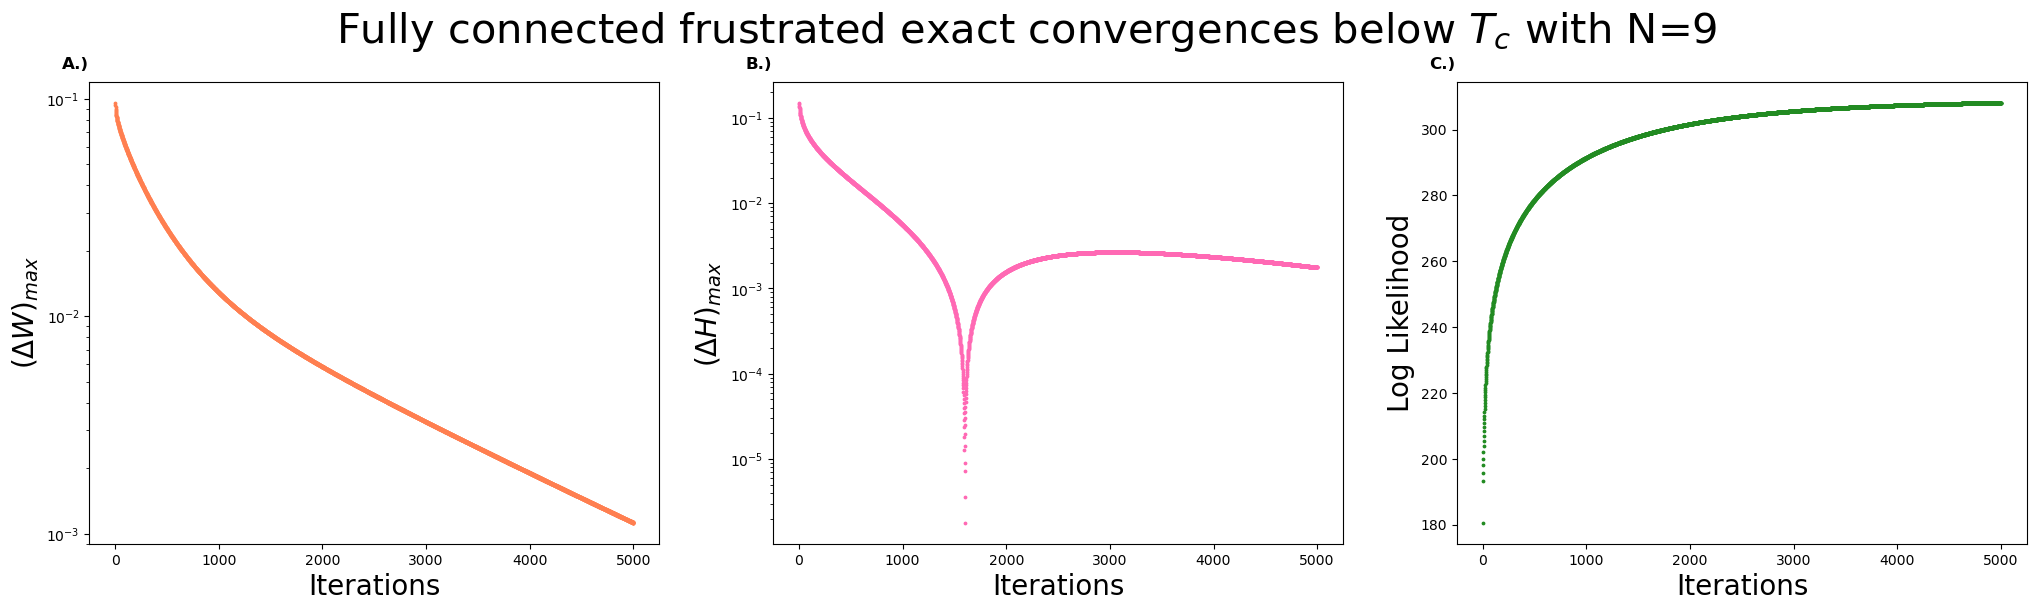

In [16]:
T = .5
maxiter = 5000

W, H, W_clamp, H_clamp, configs = initialize(L,w,h,sigma,seed_clamp,seed_free)
W, H, W_clamp, H_clamp, it, Hmax, Wmax, Li= solve_inverse_ising(L, T, eqSteps, mcSteps, W, H, W_clamp, H_clamp, configs, Clamp_type, Free_type, threshold, maxiter, eta)

plot(it, Hmax, Wmax, Li, title = ('Fully connected frustrated exact convergences below $T_c$ with N=%.f'%L**2), size = 3)
plt.savefig(f"Figures/Inverse Ising Problem/Exact_fc_const_below_Tc_L={L}_T={T}_w={w}_h={h}_eta={eta}_thresh={threshold}_it={it}.png", bbox_inches='tight')


# Results Fully Connected Nearest Neighbours [same temperature dependent effects]

In [17]:
##  PARAMETERS
#----------------------------------------------------------------------
# model parameters
L           = 3        #  linear dimension of the LxL lattice
T           = 5        #  temperature scalar
w           = 1        #  strength of interactions 
h           = 0        #  strength of self-interactions
W_type      = 1        #  0 for random weights, 1 for nb, 2 for fully connected
Clamp_type  = 0        #  determine how the clamped statistics are generated (0 exact, 1 mc)
Free_type   = 0        #  determine how the free statistics are generated (0 exact, 1 mc)
eqSteps     = 2**10    #  number of MC sweeps for equilibration
mcSteps     = 2**14    #  number of MC sweeps for calculation

# gradient ascent parameters 
eta         = 1/2      #  learning rate
threshold   = 1e-16     #  threshold for stopping the gradient ascent loop
maxiter     = 700      #  maximum number of gradient ascent iterations

#random weights parametes
seed_clamp  = 777       
seed_free   = 333
sigma       = .1

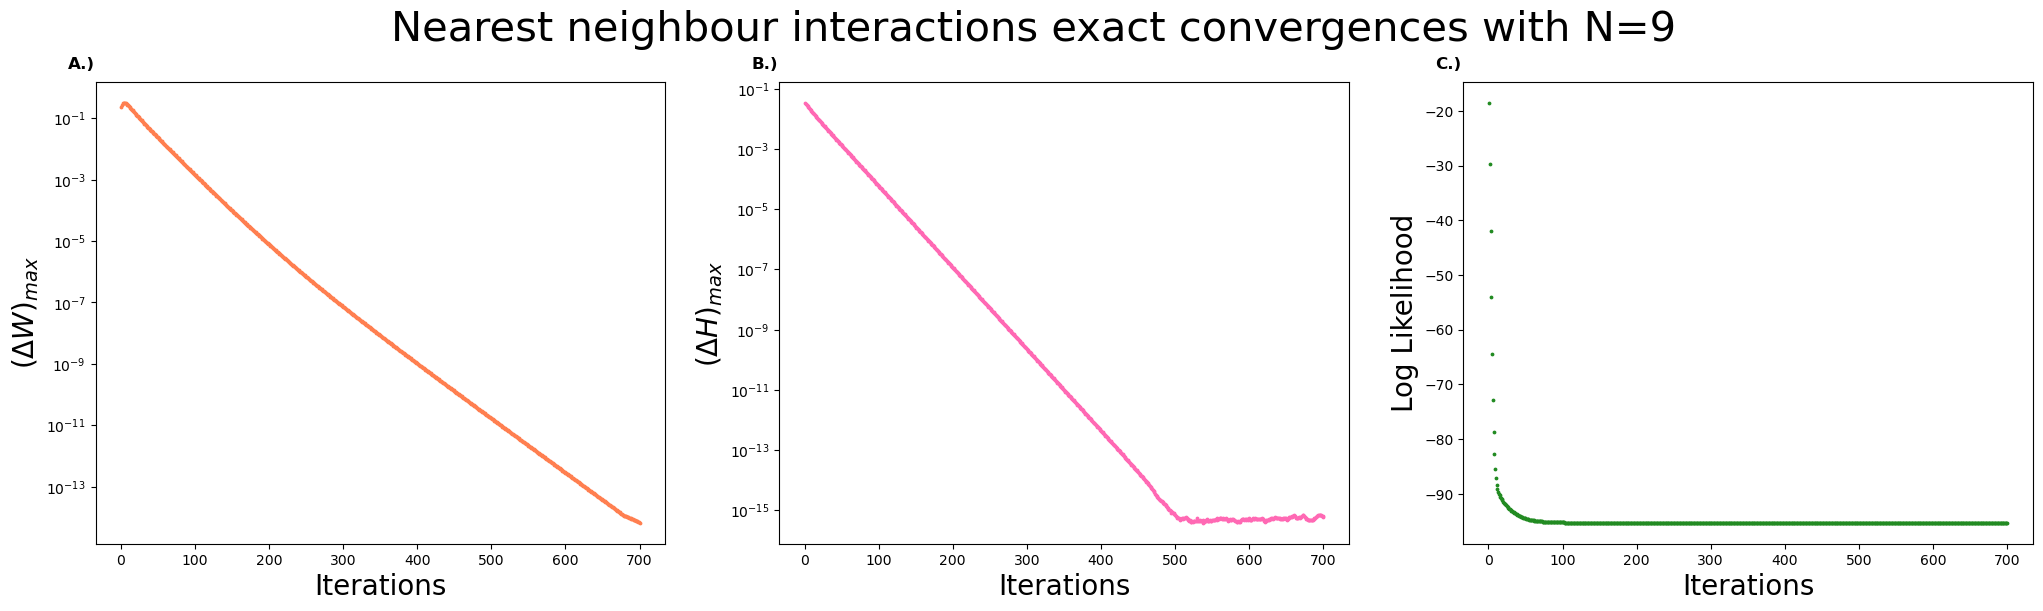

In [18]:
L = 3

W, H, W_clamp, H_clamp, configs = initialize(L,w,h,sigma,seed_clamp,seed_free)
W, H, W_clamp, H_clamp, it, Hmax, Wmax, Li= solve_inverse_ising(L, T, eqSteps, mcSteps, W, H, W_clamp, H_clamp, configs, Clamp_type, Free_type, threshold, maxiter, eta)

plot(it, Hmax, Wmax, Li, title = ('Nearest neighbour interactions exact convergences with N=%.f'%L**2), size = 3)
plt.savefig(f"Figures/Inverse Ising Problem/Exact_NB_L={L}_T={T}_w={w}_h={h}_eta={eta}_thresh={threshold}_it={it}.png", bbox_inches='tight')
